In [1]:
### Set-up for training a U-net convolutional neural network for sementic segmentation ###
import os
os.chdir('E:/BasW/Notebooks') 
work_directory = os.getcwd()
os.chdir(work_directory+'/Scripts')
from DataCreation import *
from DataPreprocessing import *
from DataAugmentation import *
from DataNormalization import *
from Unet import *
from random import sample
import tensorflow
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
os.chdir('../..') # --> ensures that work directory = E:/BasW/Notebooks
work_directory = os.getcwd()
path_training_data = "E:/BasW/Data/H5130_Totaal"

Using TensorFlow backend.


Set variables and directories

In [2]:
# Create processing objects
dc = N2000_Data(image_size = (512,512), cell_size = 0.25, epsg = 28992)
dp = N2000_DataPreparation(image_size = (512,512))
dn = DataNormalization(image_size = (512,512))

Create 4 dimensional images

In [10]:
#cir_path = f"{path_training_data}/Images/2017_2018/cir"
rgb_path = f"{path_training_data}/Images/2017_2018_Rgb/training_data"
#path_data = f"{path_training_data}/Images/2017_2018_CirRgb/training_data"
#dc.create4dimensionalImage(path_rgb_data = rgb_path, path_cir_data = cir_path, dest_folder = path_data, name = 'h5130.tif')

Compute nomalization statistics

In [11]:
## READ DATA IN A NUMPY ARRAY ##
#cir_array = dp.ImagesToArray(img_folder = cir_path, mas#cir_path = f"{path_training_data}/Images/2017_2018/cir"
rgb_path = f"{path_training_data}/Images/2017_2018_Rgb/training_data"
#path_data = f"{path_training_data}/Images/2017_2018_CirRgb/training_data"
#dc.create4dimensionalImage(path_rgb_data = rgb_path, path_cir_data = cir_path, dest_folder = path_data, name = 'h5130.tif')k = False)
rgb_array = dp.ImagesToArray(img_folder = rgb_path, mask = False)
#cir_rgb_array = dp.ImagesToArray(img_folder = path_data, mask = False)
#print(cir_rgb_array.shape)
print(rgb_array.shape)

(1189, 512, 512, 3)


In [12]:
## CALCULATE NORMALIZATION STATISTICS ##
#stats_cir_rgb = dn.CalculateNormalizationStatisticsPerBand(np_array = cir_rgb_array, csv_folder = path_data, csv_name= "2017_2018_Totaal_NormalizationCirRgbPerBand.csv", bands = 4)
#stats_cir_rgb2 = dn.CalculateNormalizationStatistics(np_array = cir_rgb_array, csv_folder = path_data, csv_name= '2017_2018_Totaal_NormalizationCirRgb.csv')
stats_rgb = dn.CalculateNormalizationStatisticsPerBand(np_array = rgb_array, csv_folder = rgb_path, csv_name= "2017_2018_Totaal_NormalizationRgbPerBand.csv", bands = 3)
stats_rgb2 = dn.CalculateNormalizationStatistics(np_array = rgb_array, csv_folder = rgb_path, csv_name= '2017_2018_Totaal_NormalizationRgb.csv')

83.078
29.877
-2.781
5.754
86.466
26.618
-3.098
6.332
84.616
23.080
-3.666
7.382
84.720
26.706
-3.172
6.376
0.000
255.000


In [13]:
### SAVE FOLDER OF IMAGES AS H5 FILE WITH FILENAMES ###
path_data = f"{path_training_data}/Images/2017_2018_Rgb/training_data"
dp.SaveTrainingData(path_data, '2017_2018_Totaal_Rgb.h5')

Load and preprocess data
- Devide image data in training- validation and test set
- Perform data augmentation on training- and validation set

In [12]:
# RUN FUNCTIONS VERSION 1: ONE H5 Files # 
folder = path_training_data+"/training/Run5"
h5Path = path_training_data + "/training/Run5/2016_2017_2018_Totaal_CirRgb.h5"
x_train, y_train, x_val, y_val, x_test, y_test, filenamesTest = dp.DevideData(path_dataset = h5Path, csv_folder = h5Path, test_size=0, validation_size=0.25) 

# Create N2000_DataAugmentation object 
# Data augmentation on training dataset
da = N2000_DataAugmentation(x_train, y_train)
x_train_hf, y_train_hf = da.HorizontalFlip(batch_size = 400)
x_train_vf, y_train_vf = da.VerticalFlip(batch_size = 400)
x_train_rr, y_train_rr = da.RandomRotation(batch_size =1000)
# Data augmentation on validation set
da2 = N2000_DataAugmentation(x_val, y_val)
x_val_hf, y_val_hf = da2.HorizontalFlip(batch_size = 100)
x_val_vf, y_val_vf = da2.VerticalFlip(batch_size = 100)
x_val_rr, y_val_rr = da2.RandomRotation(batch_size = 300)

# Merge original training data with data augmentation
x_train_total = np.concatenate([x_train,x_train_hf, x_train_vf, x_train_rr])
y_train_total = np.concatenate([y_train,y_train_hf, y_train_vf, y_train_rr])
x_val_total = np.concatenate([x_val,x_val_hf, x_val_vf, x_val_rr])
y_val_total = np.concatenate([y_val,y_val_hf, y_val_vf, y_val_rr])
print(x_train_total.shape, y_train_total.shape)
print(x_val_total.shape, y_val_total.shape)

(3138, 512, 512, 4) (3138, 512, 512, 1)
(946, 512, 512, 4) (946, 512, 512, 1)


Save training and validation dataset as separate H5-file

In [13]:
filenames = []
for i in range(len(x_train_total)):
    filename = f"{i}_trainImage"
    filenames.append(filename)
filenames_val = []
for i in range(len(x_val_total)):
    filename = f"{i}_validationImage"
    filenames_val.append(filename)
filenames_val = [n.encode("ascii", "ignore") for n in filenames_val]
filenames = [n.encode("ascii", "ignore") for n in filenames]
print(len(filenames), len(filenames_val))
# Write training dataset en validation dataset to h5-file
dp.writeH5file(images = x_train_total, masks = y_train_total, filenames = filenames, dest_h5_file = path_training_data+"/training/Run5/H5130_Totaal_CirRgb_Training_Run5.h5")
dp.writeH5file(images = x_val_total, masks = y_val_total, filenames = filenames_val, dest_h5_file = path_training_data+"/training/Run5/H5130_Totaal_CirRgb_Validation_Run5.h5")

3138 946


Load and normalize the data before training (DIFFERENT NORMALIZATION OPTIONS!)

In [3]:
stats = path_training_data+"/training/Run12/2016_2017_2018_Totaal_NormalizationCirRgb.csv"
h5_train = path_training_data+"/training/Run12/H5130_Totaal_CirRgb_Training_Run12.h5"
h5_val = path_training_data+"/training/Run12/H5130_Totaal_CirRgb_Validation_Run12.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeData(stats_file = stats, h5_file = h5_train, array_result = True)
x_val_total = dn.NormalizeData(stats_file = stats, h5_file = h5_val, array_result = True)
#x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
#x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 

(3138, 512, 512, 4) (3138, 512, 512, 1)
1.0000074 4.6122193e-05 1.0 0.0
(946, 512, 512, 4) (946, 512, 512, 1)
1.0000074 4.6122193e-05 1.0 0.0


In [7]:
train_img = x_train_total[950]
mask_img = y_train_total[950]
mask_img = mask_img.reshape(512,512)

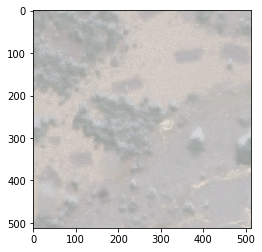

In [8]:
plt.imshow(train_img)
plt.show()


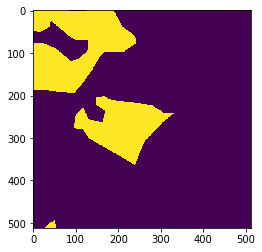

In [9]:
plt.imshow(mask_img)
plt.show()


Train U-net convolutional neural network for semantic segmentation

In [10]:
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Totaal/checkpoints"
model = unet2(input_shape = (512, 512, 4), lr=0.00001)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run12_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run12/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.000000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run12_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=6, epochs=35, verbose=2, shuffle=True, callbacks=calbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 3138 samples, validate on 946 samples
Epoch 1/35
 - 329s - loss: 0.4630 - acc: 0.7893 - val_loss: 0.3986 - val_acc: 0.8364

Epoch 00001: val_acc improved from -inf to 0.83640, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run12_weights_best.h5
Epoch 2/35
 - 304s - loss: 0.3529 - acc: 0.8562 - val_loss: 0.3233 - val_acc: 0.8658

Epoch 00002: val_acc improved from 0.83640 to 0.86575, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run12_weights_best.h5
Epoch 3/35
 - 304s - loss: 0.3283 - acc: 0.8646 - val_loss: 0.2995 - val_acc: 0.8740

Epoch 00003: val_acc improved from 0.86575 to 0.87396, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run12_weights_best.h5
Epoch 4/35
 - 305s - loss: 0.3131 - acc: 0.8711 - val_loss: 0.2807 - val_acc: 0.8865

Epoch 00004: val_acc improved from 0.87396 to 0.88647, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run12_weights_best.h5
Epoch 5/35
 - 306s - loss: 0.2985 - acc:

In [ ]:
model.summary()

In [12]:
import pickle
with open(folder_checkpoints + '/Run12_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run12.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json")

model.save_weights(folder_checkpoints + "/h5130_Weights_run12.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [3]:
## RUN 6 ##
path_training_data = "E:/BasW/Data/H5130_Totaal"
stats = path_training_data+"/training/Run6/2017_2018_Totaal_NormalizationCirRgbPerBand.csv"
h5_train = path_training_data+"/training/Run6/H5130_Totaal_CirRgb_Training_Run6.h5"
h5_val = path_training_data+"/training/Run6/H5130_Totaal_CirRgb_Validation_Run6.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Totaal/checkpoints"
model = unet(input_size = (512, 512, 4), lr=0.00001, drop_out = 0)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

83.078
86.466
84.616
114.975
83.078
86.466
84.616
114.975
(2091, 512, 512, 4) (2091, 512, 512, 1)
1.0000383 -0.015949469 1.0 0.0
(648, 512, 512, 4) (648, 512, 512, 1)
1.0000383 -0.015949469 1.0 0.0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
folder_checkpoints = "E:/BasW/Data/H5130_Totaal/checkpoints"
model = unet(input_size = (512, 512, 4), lr=0.00001, drop_out = 0)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

In [6]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run6_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run6/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run6_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=8, epochs=35, verbose=2, shuffle=True, callbacks=calbacks_list)

Train on 2091 samples, validate on 648 samples
Epoch 1/35
 - 212s - loss: 0.4524 - acc: 0.8058 - val_loss: 0.4114 - val_acc: 0.8049

Epoch 00001: val_acc improved from -inf to 0.80485, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run6_weights_best.h5
Epoch 2/35
 - 211s - loss: 0.4077 - acc: 0.8064 - val_loss: 0.4034 - val_acc: 0.8049

Epoch 00002: val_acc improved from 0.80485 to 0.80486, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run6_weights_best.h5
Epoch 3/35
 - 211s - loss: 0.3950 - acc: 0.8095 - val_loss: 0.3873 - val_acc: 0.8154

Epoch 00003: val_acc improved from 0.80486 to 0.81538, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run6_weights_best.h5
Epoch 4/35
 - 211s - loss: 0.3776 - acc: 0.8218 - val_loss: 0.3668 - val_acc: 0.8348

Epoch 00004: val_acc improved from 0.81538 to 0.83484, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run6_weights_best.h5
Epoch 5/35
 - 211s - loss: 0.3658 - acc: 0.8328 - val_loss: 0.3600 - val_acc: 0.8330

Epoch 

In [7]:
import pickle
with open(folder_checkpoints + '/Run6_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run6.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json") 

model.save_weights(folder_checkpoints + "/h5130_Weights_run6.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [3]:
## RUN 1 ##
path_training_data = "E:/BasW/Data/H5130_Overijssel"
stats = path_training_data+"/training/Run1/2016_2017_2018_Overijssel_NormalizationCirRgbPerBand.csv"
h5_train = path_training_data+"/training/Run1/H5130_Overijssel_CirRgb_Training_Run1.h5"
h5_val = path_training_data+"/training/Run1/H5130_Overijssel_CirRgb_Validation_Run1.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Overijssel/checkpoints"
model = unet(input_size = (512, 512, 4), lr=0.000005, drop_out = 0.2)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

88.105
91.263
87.753
120.418
88.105
91.263
87.753
120.418
(2181, 512, 512, 4) (2181, 512, 512, 1)
1.0000458 -0.09918374 1.0 0.0
(661, 512, 512, 4) (661, 512, 512, 1)
1.0000364 -0.09918374 1.0 0.0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
folder_checkpoints = "E:/BasW/Data/H5130_Overijssel/checkpoints"
model = unet(input_size = (512, 512, 4), lr=0.000005, drop_out = 0.2)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

In [6]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run1_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run1/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run1_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=8, epochs=25, verbose=2, shuffle=True, callbacks=calbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 2181 samples, validate on 661 samples
Epoch 1/25
 - 234s - loss: 0.4943 - acc: 0.7696 - val_loss: 0.4848 - val_acc: 0.7700

Epoch 00001: val_acc improved from -inf to 0.76995, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run1_weights_best.h5
Epoch 2/25
 - 221s - loss: 0.4670 - acc: 0.7704 - val_loss: 0.4650 - val_acc: 0.7700

Epoch 00002: val_acc improved from 0.76995 to 0.76997, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run1_weights_best.h5
Epoch 3/25
 - 220s - loss: 0.4564 - acc: 0.7756 - val_loss: 0.4693 - val_acc: 0.7724

Epoch 00003: val_acc improved from 0.76997 to 0.77241, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run1_weights_best.h5
Epoch 4/25
 - 220s - loss: 0.4477 - acc: 0.7801 - val_loss: 0.4376 - val_acc: 0.7949

Epoch 00004: val_acc improved from 0.77241 to 0.79494, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run1_weights_best.h5
Epoch 5/25
 - 221s - loss: 0

In [7]:
import pickle
with open(folder_checkpoints + '/Run1_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run1.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json") 

model.save_weights(folder_checkpoints + "/h5130_Weights_run1.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [11]:
### Run 2 ###
path_training_data = "E:/BasW/Data/H5130_Overijssel"
stats = path_training_data+"/training/Run2/2017_2018_Overijssel_NormalizationCirRgbPerBand.csv"
h5_train = path_training_data+"/training/Run2/H5130_Overijssel_CirRgb_Training_Run2.h5"
h5_val = path_training_data+"/training/Run2/H5130_Overijssel_CirRgb_Validation_Run2.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Overijssel/checkpoints"
model = unet(input_size = (512, 512, 4), lr=0.00001, drop_out = 0)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

83.931
86.418
85.576
112.056
83.931
86.418
85.576
112.056
(1520, 512, 512, 4) (1520, 512, 512, 1)
1.000012 -0.099140875 1.0 0.0
(424, 512, 512, 4) (424, 512, 512, 1)
1.000012 -0.099140875 1.0 0.0


In [12]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run2_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run2/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run2_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=8, epochs=30, verbose=2, shuffle=True, callbacks=calbacks_list)

Train on 1520 samples, validate on 424 samples
Epoch 1/30
 - 155s - loss: 0.4907 - acc: 0.7676 - val_loss: 0.4593 - val_acc: 0.7702

Epoch 00001: val_acc improved from -inf to 0.77018, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run2_weights_best.h5
Epoch 2/30
 - 152s - loss: 0.4657 - acc: 0.7677 - val_loss: 0.4441 - val_acc: 0.7702

Epoch 00002: val_acc did not improve from 0.77018
Epoch 3/30
 - 152s - loss: 0.4450 - acc: 0.7677 - val_loss: 0.4291 - val_acc: 0.7704

Epoch 00003: val_acc improved from 0.77018 to 0.77039, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run2_weights_best.h5
Epoch 4/30
 - 152s - loss: 0.4336 - acc: 0.7812 - val_loss: 0.4421 - val_acc: 0.7710

Epoch 00004: val_acc improved from 0.77039 to 0.77097, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run2_weights_best.h5
Epoch 5/30
 - 152s - loss: 0.4343 - acc: 0.7794 - val_loss: 0.4157 - val_acc: 0.7870

Epoch 00005: val_acc improved from 0.77097 to 0.78700, saving model to E:/

In [13]:
import pickle
with open(folder_checkpoints + '/Run2_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run2.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json") 

model.save_weights(folder_checkpoints + "/h5130_Weights_run2.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [8]:
### Run 3 ###
path_training_data = "E:/BasW/Data/H5130_Overijssel"
stats = path_training_data+"/training/Run3/2016_2017_2018_Overijssel_NormalizationRgbPerBand.csv"
h5_train = path_training_data+"/training/Run3/H5130_Overijssel_Rgb_Training_Run3.h5"
h5_val = path_training_data+"/training/Run3/H5130_Overijssel_Rgb_Validation_Run3.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Overijssel/checkpoints"
model = unet(input_size = (512, 512, 3), lr=0.00001, drop_out = 0.1)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

88.105
91.263
87.753
88.105
91.263
87.753
(2181, 512, 512, 3) (2181, 512, 512, 1)
1.0000364 -0.03661419 1.0 0.0
(661, 512, 512, 3) (661, 512, 512, 1)
1.0000364 -0.03661419 1.0 0.0


In [9]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run3_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run3/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run3_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=8, epochs=30, verbose=2, shuffle=True, callbacks=calbacks_list)

Train on 2181 samples, validate on 661 samples
Epoch 1/30
 - 225s - loss: 0.4885 - acc: 0.7690 - val_loss: 0.4612 - val_acc: 0.7678

Epoch 00001: val_acc improved from -inf to 0.76784, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run3_weights_best.h5
Epoch 2/30
 - 219s - loss: 0.4402 - acc: 0.7802 - val_loss: 0.4386 - val_acc: 0.7853

Epoch 00002: val_acc improved from 0.76784 to 0.78533, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run3_weights_best.h5
Epoch 3/30
 - 219s - loss: 0.4276 - acc: 0.7940 - val_loss: 0.4285 - val_acc: 0.8004

Epoch 00003: val_acc improved from 0.78533 to 0.80039, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run3_weights_best.h5
Epoch 4/30
 - 219s - loss: 0.4114 - acc: 0.8076 - val_loss: 0.4253 - val_acc: 0.8001

Epoch 00004: val_acc did not improve from 0.80039
Epoch 5/30
 - 218s - loss: 0.3958 - acc: 0.8192 - val_loss: 0.4121 - val_acc: 0.8093

Epoch 00005: val_acc improved from 0.80039 to 0.80933, saving model to E:/

In [10]:
import pickle
with open(folder_checkpoints + '/Run3_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run3.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json") 

model.save_weights(folder_checkpoints + "/h5130_Weights_run3.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [7]:
### Run 4 ###
path_training_data = "E:/BasW/Data/H5130_Overijssel"
stats = path_training_data+"/training/Run4/2017_2018_Overijssel_NormalizationRgbPerBand.csv"
h5_train = path_training_data+"/training/Run4/H5130_Overijssel_Rgb_Training_Run4.h5"
h5_val = path_training_data+"/training/Run4/H5130_Overijssel_Rgb_Validation_Run4.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Overijssel/checkpoints"
model = unet(input_size = (512, 512, 3), lr=0.00001, drop_out = 0)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

83.931
86.418
85.576
83.931
86.418
85.576
(1520, 512, 512, 3) (1520, 512, 512, 1)
1.000012 -0.036539275 1.0 0.0
(424, 512, 512, 3) (424, 512, 512, 1)
0.9999608 -0.036539275 1.0 0.0


In [12]:
folder_checkpoints = "E:/BasW/Data/H5130_Overijssel/checkpoints"
model = unet(input_size = (512, 512, 3), lr=0.000001, drop_out = 0)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

In [13]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run4_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 4)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run4/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run4_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=8, epochs=35, verbose=2, shuffle=True, callbacks=calbacks_list)

Train on 1520 samples, validate on 424 samples
Epoch 1/35
 - 150s - loss: 0.5721 - acc: 0.7762 - val_loss: 0.5027 - val_acc: 0.7740

Epoch 00001: val_acc improved from -inf to 0.77401, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run4_weights_best.h5
Epoch 2/35
 - 149s - loss: 0.4830 - acc: 0.7762 - val_loss: 0.4586 - val_acc: 0.7740

Epoch 00002: val_acc improved from 0.77401 to 0.77401, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run4_weights_best.h5
Epoch 3/35
 - 149s - loss: 0.4563 - acc: 0.7762 - val_loss: 0.4403 - val_acc: 0.7740

Epoch 00003: val_acc improved from 0.77401 to 0.77401, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run4_weights_best.h5
Epoch 4/35
 - 149s - loss: 0.4415 - acc: 0.7762 - val_loss: 0.4336 - val_acc: 0.7740

Epoch 00004: val_acc improved from 0.77401 to 0.77402, saving model to E:/BasW/Data/H5130_Overijssel/checkpoints/Run4_weights_best.h5
Epoch 5/35
 - 151s - loss: 0.4361 - acc: 0.7762 - val_loss: 0.4259 - val_acc

In [14]:
import pickle
with open(folder_checkpoints + '/Run4_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run4.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json") 

model.save_weights(folder_checkpoints + "/h5130_Weights_run4.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [4]:
## RUN 8 ###
path_training_data = "E:/BasW/Data/H5130_Totaal"
stats = path_training_data+"/training/Run8/2017_2018_Totaal_NormalizationRgbPerBand.csv"
h5_train = path_training_data+"/training/Run8/H5130_Totaal_Rgb_Training_Run8.h5"
h5_val = path_training_data+"/training/Run8/H5130_Totaal_Rgb_Validation_Run8.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
if np.max(y_val_total) > 1:
    y_val_total = y_val_total.astype('float32')
    y_val_total /= 255
if np.max(y_train_total > 1):
    y_train_total = y_train_total.astype('float32')
    y_train_total /= 255
    
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Totaal/checkpoints"
model = unet(input_size = (512, 512, 3), lr=0.00001, drop_out = 0)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

83.078
86.466
84.616
83.078
86.466
84.616
(2091, 512, 512, 3) (2091, 512, 512, 1)
1.0000383 -0.015949469 1.0 0.0
(648, 512, 512, 3) (648, 512, 512, 1)
1.0000383 -0.015949469 1.0 0.0


In [5]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run8_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 4)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run8/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run8_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=8, epochs=35, verbose=2, shuffle=True, callbacks=calbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 2091 samples, validate on 648 samples
Epoch 1/35
 - 230s - loss: 0.4607 - acc: 0.7977 - val_loss: 0.4272 - val_acc: 0.8110

Epoch 00001: val_acc improved from -inf to 0.81100, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run8_weights_best.h5
Epoch 2/35
 - 214s - loss: 0.4346 - acc: 0.8006 - val_loss: 0.4233 - val_acc: 0.8110

Epoch 00002: val_acc did not improve from 0.81100
Epoch 3/35
 - 209s - loss: 0.4212 - acc: 0.8076 - val_loss: 0.4328 - val_acc: 0.8110

Epoch 00003: val_acc did not improve from 0.81100
Epoch 4/35
 - 209s - loss: 0.4100 - acc: 0.8136 - val_loss: 0.3917 - val_acc: 0.8282

Epoch 00004: val_acc improved from 0.81100 to 0.82818, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run8_weights_best.h5
Epoch 5/35
 - 209s - loss: 0.3952 - acc: 0.8203 - val_loss: 0.3697 - val_acc: 0.8306

Epoch 00005: val_acc improved from 0.82818 to 0.83062, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run8_weig

In [6]:
import pickle
with open(folder_checkpoints + '/Run8_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run8.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json") 

model.save_weights(folder_checkpoints + "/h5130_Weights_run8.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [15]:
## RUN 7 ###
path_training_data = "E:/BasW/Data/H5130_Totaal"
stats = path_training_data+"/training/Run7/2016_2017_2018_Totaal_NormalizationRgbPerBand.csv"
h5_train = path_training_data+"/training/Run7/H5130_Totaal_Rgb_Training_Run7.h5"
h5_val = path_training_data+"/training/Run7/H5130_Totaal_Rgb_Validation_Run7.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
if np.max(y_val_total) > 1:
    y_val_total = y_val_total.astype('float32')
    y_val_total /= 255
if np.max(y_train_total > 1):
    y_train_total = y_train_total.astype('float32')
    y_train_total /= 255
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 
    
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/H5130_Totaal/checkpoints"
model = unet(input_size = (512, 512, 3), lr=0.00001, drop_out = 0)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

86.042
90.52
86.322
86.042
90.52
86.322
(3138, 512, 512, 3) (3138, 512, 512, 1)
1.0000403 -0.015939804 1.0 0.0
(946, 512, 512, 3) (946, 512, 512, 1)
1.0000403 -0.015939804 1.0 0.0


In [16]:
# Checkpoints
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run7_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 4)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run7/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,  min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run7_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, reduce_lr, csv_logger]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=8, epochs=35, verbose=2, shuffle=True, callbacks=calbacks_list)

Train on 3138 samples, validate on 946 samples
Epoch 1/35
 - 325s - loss: 0.3351 - acc: 0.8074 - val_loss: 0.3262 - val_acc: 0.8025

Epoch 00001: val_acc improved from -inf to 0.80255, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run7_weights_best.h5
Epoch 2/35
 - 310s - loss: 0.3118 - acc: 0.8081 - val_loss: 0.3275 - val_acc: 0.8106

Epoch 00002: val_acc improved from 0.80255 to 0.81059, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run7_weights_best.h5
Epoch 3/35
 - 311s - loss: 0.3026 - acc: 0.8121 - val_loss: 0.2891 - val_acc: 0.8219

Epoch 00003: val_acc improved from 0.81059 to 0.82188, saving model to E:/BasW/Data/H5130_Totaal/checkpoints/Run7_weights_best.h5
Epoch 4/35
 - 311s - loss: 0.2859 - acc: 0.8170 - val_loss: 0.3018 - val_acc: 0.8116

Epoch 00004: val_acc did not improve from 0.82188
Epoch 5/35
 - 310s - loss: 0.2781 - acc: 0.8188 - val_loss: 0.2709 - val_acc: 0.8211

Epoch 00005: val_acc did not improve from 0.82188
Epoch 6/35
 - 310s - loss: 0.2576 - 

KeyboardInterrupt: 

In [17]:
# import pickle
# with open(folder_checkpoints + '/Run7_trainHistory', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)
    
model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/h5130_run7.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json") 

model.save_weights(folder_checkpoints + "/h5130_Weights_run7.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [ ]:
from matplotlib import pyplot
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# evaluate the model
#_, train_acc = model.evaluate(x_train, y_train, verbose=0)
#_, test_acc = model.evaluate(x_test, y_test, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))